# Deep Learning for Computer Vision: Semantic Segmentation

Modified by: Harold Mouchère / Nantes University

date: 2024


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Questions are at the end of the notebook**

## Introduction

In this lab, we will we will work with the PASCAL VOC 2012 dataset, which is widely used for object detection, classification, and segmentation tasks. The dataset contains images from 20 object categories, including people, animals, and vehicles, with annotations for both object detection (bounding boxes) and segmentation (masks).

Our goal in this project will be to train a model for semantic segmentation, where we classify each pixel as with its class label.

We will begin by downloading the dataset, loading the data, and visualizing some sample images with their ground truth mask.

In [2]:
# Import necessary libraries
import os
import torch
#from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torch.nn as nn
import torch.nn.functional as TF
from torchvision.models import segmentation
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import v2
from torchvision import datasets, tv_tensors

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import collections

from sklearn.metrics import precision_recall_curve, auc

import matplotlib.pyplot as plt

from tqdm import tqdm  # For progress bar

if torch.cuda.is_available():
	print("CUDA is available")
else:
	print("CUDA is not available")

CUDA is not available


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")

In [4]:
# Specify where you want to store the dataset
dataset_root = '../content/drive/MyDrive/Cours/data'  # You can specify a different directory if needed

# Download the PASCAL VOC 2012 trainval dataset
train_dataset = torchvision.datasets.VOCSegmentation(
    root=dataset_root,
    year='2012',            # Download the 2012 version
    image_set='train',    # Download the trainval split
    download=False,           # Set to False if the dataset is already present
    transform=transforms.ToTensor()  # Transform to Tensor
)

val_dataset = torchvision.datasets.VOCSegmentation(
    root=dataset_root,
    year='2012',
    image_set='val',
    download= False,           # Set to False if the dataset is already present
    transform=transforms.ToTensor()  # Transform to Tensor
)

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

VOC_CLASSE_NAMES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

print(f"Training Dataset size: {len(train_dataset)} images")
print(f"Validation Dataset size: {len(val_dataset)} images")

Training Dataset size: 1464 images
Validation Dataset size: 1449 images


(281, 500)
0


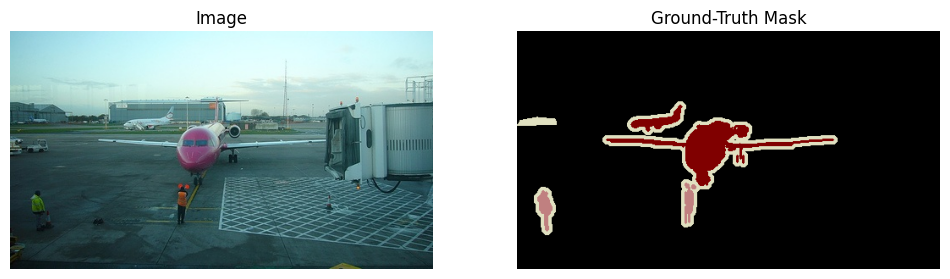

In [5]:
# Load one image and its ground-truth
image, target = train_dataset[0]

# Convert the image tensor to a PIL image for visualization
image_pil = to_pil_image(image)

# Create a color map for the segmentation mask
colormap = np.array(VOC_COLORMAP, dtype=np.uint8)
colormap.resize((256, 3))
colormap[255] =  [224, 224, 192]  # Add the color for the 'void' class
# Convert the target mask to a color image

mask = np.array(target).astype(np.uint8)
print(mask.shape)
mask_color = colormap[mask]
print(np.array(target)[100,100])

# Plot the image and its ground-truth mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_pil)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(mask_color)
ax[1].set_title('Ground-Truth Mask')
ax[1].axis('off')

plt.show()

### Visualizing function

Here are a few utility functions that will allow you to visualize predictions made by the model.

In [6]:
def load_image(image_path):
    """Load an image from file."""
    image = Image.open(image_path).convert("RGB")
    return image

def prepare_image(image, transform=None):
    """Prepare the image for model input."""
    if transform:
        image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

def visualize_predictions(image, outputMask, unnormalize=True):
    """Visualize the bounding boxes and labels on the image."""
    # Unnormalize the image
    if unnormalize:
        image = F.normalize(image, (-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225), (1 / 0.229, 1 / 0.224, 1 / 0.225))
    # put everything on the cpu
    image = image.to('cpu')
    outputMask = outputMask.to('cpu')
    #print(outputMask.shape)
    # if tensor wwith scores, get the class with the highest score
    if len(outputMask.shape) == 3:
        mask = torch.argmax(outputMask, dim=0)
    else:
        mask = outputMask

    # Create a color map for the segmentation mask
    colormap = np.array(VOC_COLORMAP, dtype=np.uint8)
    colormap.resize((256, 3))
    colormap[255] =  [224, 224, 192]  # Add the color for the 'void' class
    mask_color = colormap[mask.numpy()]

    # get all the classes from the mask
    classes = torch.unique(mask)
    # remove the void class
    classes = classes[classes != 255]
    #list them with their name
    # print(classes)
    classes_names = [VOC_CLASSE_NAMES[i] for i in classes]
    print(classes_names)


   # Plot the image and its ground-truth mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    #print(type(image))
    #if type(image) == torch.Tensor:
    #    image = to_pil_image(image)
    ax[0].imshow(image.permute(1, 2, 0).numpy())
    #ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask_color)
    ax[1].set_title('Output Mask')
    ax[1].axis('off')
    plt.show()

### Inference with trained models

We will use a pre-trained model for semantic segmentation. We will load the model and use it to make predictions on some sample images from the dataset.

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


100%|██████████| 135M/135M [00:01<00:00, 108MB/s] 


['background', 'motorbike']


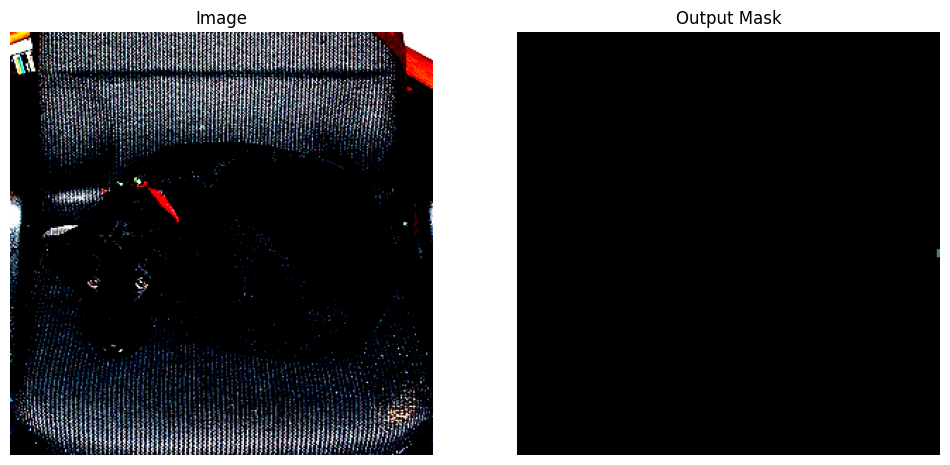

<built-in method size of Tensor object at 0x7e5750562440> 12


In [14]:

# get the image and the target from the dataset
img, target = train_dataset[2]

# Step 1: Initialize model with the best available weights
weights = segmentation.FCN_ResNet50_Weights.DEFAULT
model = segmentation.fcn_resnet50(weights=weights)
# weights = segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT
# model = segmentation.lraspp_mobilenet_v3_large(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)
#batch = img.unsqueeze(0)

# Step 4: Use the model and visualize the prediction
prediction = model(batch)["out"]
# some do not include the softmax:
normalized_masks = prediction.softmax(dim=1)
visualize_predictions(img, normalized_masks[0], False)
#visualize_predictions(img, target)
print(target.size, np.array(target)[100,100])


## Your model

Now let's define a new model for semantic segmentation and train it on the PASCAL VOC 2012 dataset.

In [15]:
class SimpleSegmentationModel(torch.nn.Module):
	def __init__(self, num_classes):
		super(SimpleSegmentationModel, self).__init__()
		self.num_classes = num_classes
		self.backbone = torch.nn.Sequential(
			torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
			torch.nn.BatchNorm2d(64),
			torch.nn.ReLU(),
			torch.nn.Conv2d(64, 128, kernel_size=3, padding=2, dilation=2),
			torch.nn.BatchNorm2d(128),
			torch.nn.ReLU(),
			torch.nn.Conv2d(128, 256, kernel_size=3, padding=4, dilation=4),
			torch.nn.BatchNorm2d(256),
			torch.nn.ReLU(),
		)
		self.classifier = torch.nn.Conv2d(256, num_classes, kernel_size=1) # Corrected input channels to 256

	def forward(self, x):
		x = self.backbone(x)
		x = self.classifier(x)
		# softmax is needed for the output to represent a probability distribution
		x = torch.nn.functional.softmax(x, dim=1)
		return x

In [16]:
class SimpleUNetLike(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=4, dilation=4),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128 + 256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.classifier = nn.Conv2d(128, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)   # 64
        x2 = self.conv2(x1)  # 128
        x3 = self.conv3(x2)  # 256

        up = TF.interpolate(x3, size=x2.shape[2:], mode="bilinear", align_corners=False)

        # Safe skip connection
        merged = torch.cat([up, x2], dim=1)

        decoded = self.decoder(merged)
        out = self.classifier(decoded)
        out = TF.softmax(out, dim=1)
        return out


### Training loop

Here, we will train our model. Be careful with the learning rate !
Sizes of the subsets are very small to speed up the training loops, but you can increase them when your code is working.

In [17]:
def compute_iou(pred_mask, true_mask, num_classes):
    if torch.is_tensor(pred_mask):
        pred_mask = pred_mask.detach().cpu().numpy()
    if torch.is_tensor(true_mask):
        true_mask = true_mask.detach().cpu().numpy()

    iou_per_class = []
    for c in range(num_classes):
        intersection = np.logical_and(pred_mask == c, true_mask == c).sum()
        union = np.logical_or(pred_mask == c, true_mask == c).sum()
        if union == 0:
            iou_per_class.append(np.nan)
        else:
            iou_per_class.append(intersection / union)
    mean_iou = np.nanmean(iou_per_class)
    return iou_per_class, mean_iou

In [18]:
def compute_map(pred_probs, true_masks, num_classes, thresholds=None):

    if thresholds is None:
        thresholds = np.linspace(0.5, 0.95, 10)

    pred_probs = pred_probs.detach().cpu().numpy()
    true_masks = true_masks.detach().cpu().numpy()

    map_per_class = []

    for c in range(num_classes):
        y_true = (true_masks == c).astype(np.uint8).ravel()
        y_score = pred_probs[:, c, :, :].ravel()
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ap = auc(recall, precision)
        map_per_class.append(ap)

    mean_map = np.nanmean(map_per_class)
    return map_per_class, mean_map

def evaluate_map(model, val_loader, num_classes, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            targets = targets.squeeze(1).long()

            outputs = model(images)
            if isinstance(outputs, dict) and 'out' in outputs:
                outputs = outputs['out']

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.append(probs.cpu())
            all_targets.append(targets.cpu())

    all_probs = torch.cat(all_probs)
    all_targets = torch.cat(all_targets)

    map_per_class, mean_map = compute_map(all_probs, all_targets, num_classes)
    print(f"\nFinal Evaluation on Validation Set:")
    print(f"Mean AP (mAP): {mean_map:.4f}")

    return map_per_class, mean_map

torch.Size([8, 3, 300, 300])
torch.Size([8, 300, 300])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=torch.uint8)
['background', 'aeroplane']


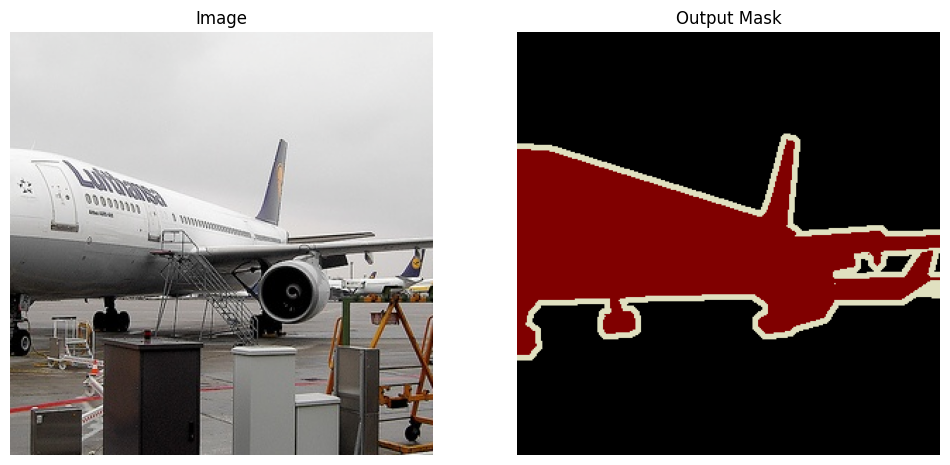

In [19]:
# Hyperparameters
num_epochs = 6
learning_rate =0.01
batch_size = 8
val_size = 200  # Number of validation images
train_size = 500  # Number of training images
num_classes=len(VOC_CLASSE_NAMES)

#model = SimpleUNetLike(num_classes)
model.train()

# Define the transforms for the image and target
mytransforms = v2.Compose(
    [
        v2.CenterCrop((300, 300)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
mytransformsT = v2.Compose(
    [
        v2.CenterCrop((300, 300)),
        v2.Lambda(lambda x: torch.as_tensor(np.array(x))),
    ]
)

# Recreate the training and validation datasets with the corresponding transforms and fixed sizes
train_dataset = torchvision.datasets.VOCSegmentation(
    root=dataset_root,
    year='2012',            # Download the 2012 version
    image_set='train',    # Download the trainval split
    download=False,           # Set to False if the dataset is already present
	transform = mytransforms,
    target_transform=mytransformsT
)

val_dataset = torchvision.datasets.VOCSegmentation(
    root=dataset_root,
    year='2012',
    image_set='val',
    download= False,           # Set to False if the dataset is already present
	transform = mytransforms,
    target_transform=mytransformsT
)

# Split into training and validation datasets
train_subset = Subset(train_dataset, range(train_size))
val_subset = Subset(val_dataset, range(val_size))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Check the size of the first batch for debugging
for img, target in val_loader:
    print(img.shape)
    print(target.shape)
    print(target[0,150:170,150])
    break
visualize_predictions(img[0], target[0], unnormalize=True)


In [ ]:
# # Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# Set up the loss function
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)

# Function for validation
def validate(model, val_loader, num_classes):
    val_loss = 0.0
    total_iou = []

    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            targets = targets.squeeze(1).long()

            outputs = model(images)
            # If model returns a dict (e.g., torchvision segmentation models), extract the tensor
            if isinstance(outputs, dict) and 'out' in outputs:
                outputs = outputs['out']

            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

            # Predicted masks
            preds = torch.argmax(outputs, dim=1)

            # IoU
            for i in range(images.size(0)):
                _, iou = compute_iou(preds[i], targets[i], num_classes)
                total_iou.append(iou)

    mean_iou = np.nanmean(total_iou)
    avg_loss = val_loss / len(val_loader)

    return avg_loss, mean_iou


val_err_array = np.array([])
train_err_array = np.array([])
nb_sample_array = np.array([])

# Training loop
best_val_loss = float('inf')  # Initialize best validation loss
for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()
    nb_used_sample = 0  # Set the model to training mode
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Move images and targets to the device (GPU or CPU)
        images = images.to(device)
        targets = targets.to(device)
        targets = targets.squeeze(1)# remove the channel dimension
        targets = targets.long()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict) and 'out' in outputs:
            outputs = outputs['out']

        # Compute total loss
        losses = loss_fn(outputs, targets)

        # Backward pass
        losses.backward()

        # Update the weights
        optimizer.step()

        # Accumulate loss
        epoch_loss += losses.item()
        nb_used_sample += batch_size

    # Print epoch loss
    train_err = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_err}")
    train_err_array = np.append(train_err_array, train_err)

    # Validate after each epoch
    val_loss, val_iou = validate(model, val_loader, num_classes)
    val_err_array = np.append(val_err_array, val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

    nb_sample_array = np.append(nb_sample_array, nb_used_sample)

    # Save the model weights if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'myNetwork_best.pth')
        print(f"Model improved: Validation loss={best_val_loss:.4f}, mIoU={val_iou:.4f}")

# Final message
print("Training complete.")

# Load best model before computing mAP
model.load_state_dict(torch.load('myNetwork_best.pth'))
map_per_class, mean_map = evaluate_map(model, val_loader, num_classes, device)


Epoch 1/6:  19%|█▉        | 12/63 [10:34<43:58, 51.73s/it]

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), map_per_class, tick_label=VOC_CLASSE_NAMES)
plt.xlabel('Classes')
plt.ylabel('mAP')
plt.title('mAP per Class')
plt.show()

In [ ]:
plt.plot(range(len(train_err_array)), train_err_array, label='Training Loss')
plt.plot(range(len(val_err_array)), val_err_array, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualization of results

In [ ]:

# Load a single image for inference
image_path = dataset_root+'/VOCdevkit/VOC2012/JPEGImages/2007_000175.jpg'  # Replace with your image path
image = load_image(image_path)

print(image)
# Prepare the model for inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Prepare the image
    input_image_ = prepare_image(image, transform=mytransforms)
    input_image = input_image_.to(device)

    # Run inference
    predictions = model(input_image)

# downloaded model uses a dictionary for the output
if isinstance(predictions,collections.OrderedDict):
    predictions = predictions['out']
print(predictions.shape)
print(input_image_.shape)
# Visualize the results
visualize_predictions(input_image_[0], predictions[0], unnormalize=True)

## Questions

1. Propose fonctions to evaluate the model on the validation set. You can use the IoU (Intersection over Union) and
   mAP (mean Average Precision) metrics.
2. With these metrics, compare the results of the pre-trained models
   - lraspp_mobilenet_v3_large
   - fcn_resnet50
3. Add in the training loop the metrics computation on the validation set to monitor the training.
4. Propose a new model for semantic segmentation and train it on the PASCAL VOC 2012 dataset.
   - a. Use only convolutional layers with kernel size 3x3 and 1x1, try dilated convolutions.
   - b. Use skip connections to improve, as in the U-Net model. Does it improve the results ?

2. mAP  and mIoU for the models (6 epoch, val_size = 200, train_size = 500):
lraspp_mobilenet_v3_large
- mAP = 0.7896
- mIoU = 0.5975

fcn_resnet50
- mAP = 0.6197
- mIoU =

It seems that lraspp_mobilenet_v3_large gives slightly better results than fc_resnet50 in terms of mAP and mIoU


4. mAP for :

Normal model : 0.0494

With more convolutions : 0.0496

With dilated convolution : 0.0530

With skip connections : 0.0593

The mAP gets better with every additions to thz model. We can note that the mAP are pretty bad since the model lacks a lot of training (cf. AP/class graph where only the dominant class, the background, is better recognized than the rest), we can still see that adding skip connections seems to improve the results.